In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(1, parentdir+'/src')
import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import time
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import gym
import pybullet as p
import stage.envs
from stage.tasks.twolink.reaching import TwoLinkReaching
from stage.utils.nn import use_gpu
use_gpu()

In [4]:
savepath = parentdir + '/data/twolink/'

In [5]:
task = TwoLinkReaching(render=False)

# Read task parameters, should we use a separate class to wrap this?

nq, nv, nu, nx = task.nq, task.nv, task.nu, task.nx
dt_control, dt_env = task.dt_control, task.dt_env
q_lb, q_ub = task.q_lb, task.q_ub

In [6]:
# Setup action parameterization

from stage.controllers.actor import Actor
from stage.controllers.trivial import Identity
from stage.controllers.pd import PD


# na = 2
# action_ub = torch.Tensor(task.env.action_space.high)
# action_lb = torch.Tensor(task.env.action_space.low)

# actor = Actor(na, Identity(nq, nv, nu), action_lb, action_ub)

na = 4
gain_ub = 50 * torch.ones((nq))
gain_lb = 0. * torch.ones((nq))

action_ub = torch.cat((gain_ub, q_ub))
action_lb = torch.cat((gain_lb, q_lb))

actor = Actor(na, PD(nq, nv, nu), action_lb, action_ub)

In [7]:
# Setup model learning

from stage.dynamics.mlp import MLPDyn, DefaultDx
dynamics = MLPDyn(nx, nq, nv, na, dt_control, DefaultDx)

# from stage.dynamics.probabilistic_ensemble import ProbabilisticEnsemble, DefaultDx
# ensemble_size = 5
# dynamics = ProbabilisticEnsemble(nq, nv, na, dt_control, 
#                                  DefaultDx,
#                                  ensemble_size)

In [8]:
# Setup controller
from stage.controllers.trivial import RandomController

controller = RandomController(nx, actor)

In [9]:
# Setup learner

from stage.learners.learn_and_control_model import LearnAndControlModel
learner = LearnAndControlModel(task, dynamics, controller)

In [10]:
_ = learner.learn(10, verbose=True)
learner.save_training_data(savepath+'data_pd_reg')

Network training: 100%|██████████| 10/10 [00:00<00:00, 21.09epoch(s)/s, Training loss MSE=3.4139507]


Iteration:  0
avg. decision time:  0.004619934558868408
obs. reward:  -257.5872
act. reward:  -1.3800364


Network training: 100%|██████████| 10/10 [00:01<00:00,  6.91epoch(s)/s, Training loss MSE=1.5340579]


Iteration:  1
avg. decision time:  0.004843318462371826
obs. reward:  -276.43225
act. reward:  -1.2010182


Network training: 100%|██████████| 10/10 [00:02<00:00,  4.81epoch(s)/s, Training loss MSE=1.3141091]


Iteration:  2
avg. decision time:  0.004759252071380615
obs. reward:  -225.55566
act. reward:  -1.3023721


Network training: 100%|██████████| 10/10 [00:02<00:00,  3.71epoch(s)/s, Training loss MSE=1.4927627]


Iteration:  3
avg. decision time:  0.004794483184814453
obs. reward:  -251.99709
act. reward:  -1.1368225


Network training: 100%|██████████| 10/10 [00:03<00:00,  3.05epoch(s)/s, Training loss MSE=1.1966151]


Iteration:  4
avg. decision time:  0.004744112491607666
obs. reward:  -184.30621
act. reward:  -1.4086415


Network training: 100%|██████████| 10/10 [00:03<00:00,  2.56epoch(s)/s, Training loss MSE=1.1001052]


Iteration:  5
avg. decision time:  0.00474449634552002
obs. reward:  -246.43057
act. reward:  -1.3319503


Network training: 100%|██████████| 10/10 [00:02<00:00,  4.39epoch(s)/s, Training loss MSE=0.96247184]


Iteration:  6
avg. decision time:  0.004742827415466309
obs. reward:  -278.0562
act. reward:  -1.5804038


Network training: 100%|██████████| 10/10 [00:01<00:00,  6.59epoch(s)/s, Training loss MSE=0.8426964]


Iteration:  7
avg. decision time:  0.004507997035980225
obs. reward:  -155.40045
act. reward:  -1.3442844


Network training: 100%|██████████| 10/10 [00:01<00:00,  5.84epoch(s)/s, Training loss MSE=0.8364982]


Iteration:  8
avg. decision time:  0.004488742351531983
obs. reward:  -213.10384
act. reward:  -1.4061123


Network training: 100%|██████████| 10/10 [00:01<00:00,  5.09epoch(s)/s, Training loss MSE=0.8099697]

Iteration:  9
avg. decision time:  0.004500577449798584
obs. reward:  -217.30296
act. reward:  -1.481793


In [11]:
traj, log = task.perform(task.goal, controller)
act_seq = traj[:, nx:nx+na]
initial_obs = traj[0, :nx]
final_obs = traj[-1, :nx]

avg. decision time:  0.00452869176864624
obs. reward:  -298.9904
act. reward:  -1.4660925


In [12]:
n_sample = 50
traj_pred = dynamics.unroll(initial_obs, 
                            act_seq, 
                            n_sample)

predicted_err = torch.norm(traj_pred[-1, :, :]-final_obs.expand(n_sample, -1), p=2, dim=1)
print (predicted_err.mean())
print (predicted_err.std())

tensor(5.0289, grad_fn=<MeanBackward0>)
tensor(3.2932, grad_fn=<StdBackward0>)


In [13]:
prediction = dynamics.sample_predictions(initial_obs, act_seq[0], n_particles=0, diff=True)

In [14]:
task_horizon = task.task_horizon

traj_pred_mean = torch.mean(traj_pred, dim=1)
traj_pred_std = torch.std(traj_pred, dim=1)
traj_pred_mean = traj_pred_mean.detach().cpu().numpy()
traj_pred_std = traj_pred_std.detach().cpu().numpy()
traj = traj.detach().cpu().numpy()

desired = task.step_cost.desired.repeat((task_horizon, 1))
desired = desired.detach().cpu().numpy()

In [15]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

In [16]:
# traj_pred_mean = np.load('traj_pred_mean.npy')
# traj_pred_std = np.load('traj_pred_std.npy')
# traj = np.load('traj.npy')

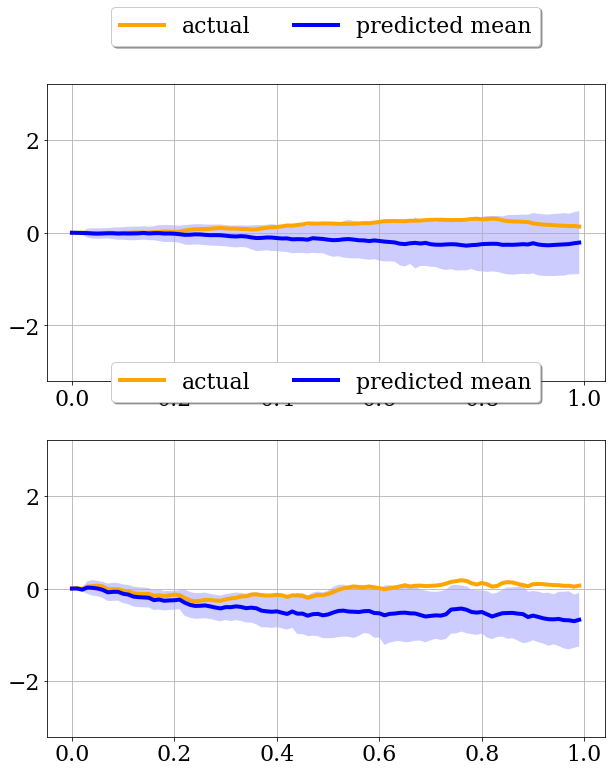

In [17]:
d = nq
dt = dt_control
fig, ax = plt.subplots(d, figsize=(10, d * 6))
t = np.arange(0.0, task_horizon*dt, dt)
dlb = traj_pred_mean - traj_pred_std
ub = traj_pred_mean + traj_pred_std

for i in range(d):
    ax[i].plot(t, traj[:, i], lw=4, color='orange', label='actual')
    ax[i].plot(t, traj_pred_mean[:, i], lw=4, color='b', label='predicted mean')
#     ax[i].plot(t, desired[:, i], lw=2, color='k', ls='-.', label='desired')
    lb = traj_pred_mean - traj_pred_std
    ub = traj_pred_mean + traj_pred_std
    ax[i].fill_between(t, lb[:, i], ub[:, i], facecolor='blue',
                alpha=0.2)
    _ = ax[i].grid()
    _ = ax[i].set_ylim([-3.2, 3.2])
    ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
             ncol=3, fancybox=True, shadow=True)
# fig.savefig('prediction_with_reg_150steps' + '.png', bbox_inches='tight')